##Image Classification on CIFAR-10
In this problem we will explore different deep learning architectures for image classification on the CIFAR-10 dataset. Make sure that you are familiar with torch `Tensor`s, two-dimensional convolutions (`nn.Conv2d`) and fully-connected layers (`nn.Linear`), ReLU non-linearities (`F.relu`), pooling (`nn.MaxPool2d`), and tensor reshaping (`view`).

We will use Colab because it has free GPU runtimes available; GPUs can accelerate training times for this problem by 10-100x. **You will need to enable the GPU runtime to use it**. To do so, click "Runtime" above and then "Change runtime type". There under hardware accelerator choose "GPU".

This notebook provides some starter code for the CIFAR-10 problem on HW4, including a completed training loop to assist with some of the Pytorch setup. You'll need to modify this code to implement the layers required for the assignment, but this provides a working training loop to start from.

*Note: GPU runtimes are limited on Colab. Limit your training to short-running jobs (around 20mins or less) and spread training out over time, if possible. Colab WILL limit your usage of GPU time, so plan ahead and be prepared to take breaks during training.* We also suggest performing your early coding/sweeps on a small fraction of the dataset (~10%) to minimize training time and GPU usage.

In [1]:
import torch
from torch import nn

from typing import Tuple, Union, List, Callable
from torch.optim import SGD
import torchvision
from torch.utils.data import DataLoader, TensorDataset, random_split
import matplotlib.pyplot as plt
from tqdm import tqdm, trange

Let's verify that we are using a gpu:

In [ ]:
assert torch.cuda.is_available(), "GPU is not available, check the directions above (or disable this assertion to use CPU)"

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)  # this should print out CUDA

cuda


To use the GPU you will need to send both the model and data to a device; this transfers the model from its default location on CPU to the GPU.

Note that torch operations on Tensors will fail if they are not located on the same device.

```python
model = model.to(DEVICE)  # Sending a model to GPU

for x, y in tqdm(data_loader):
  x, y = x.to(DEVICE), y.to(DEVICE)
```
When reading tensors you may need to send them back to cpu, you can do so with `x = x.cpu()`.

Let's load CIFAR-10 data. This is how we load datasets using PyTorch in the real world!

In [ ]:
train_dataset = torchvision.datasets.CIFAR10("./data", train=True, download=True, transform=torchvision.transforms.ToTensor())
test_dataset = torchvision.datasets.CIFAR10("./data", train=False, download=True, transform=torchvision.transforms.ToTensor())

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Here, we'll use the torch `DataLoader` to wrap our datasets. `DataLoader`s handle batching, shuffling, and iterating over data; they can also be useful for building more complex input pipelines that perform transfoermations such as data augmentation.

In [ ]:
batch_size = 128

#train_dataset, _ = random_split(train_dataset, [int(0.1 * len(train_dataset)), int( 0.9 * len(train_dataset))])

train_dataset, val_dataset = random_split(train_dataset, [int(0.9 * len(train_dataset)), int( 0.1 * len(train_dataset))])

# Create separate dataloaders for the train, test, and validation set
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=True
)

Let's define a method to train this model using SGD as our optimizer.

In [ ]:
def train(
    model: nn.Module, optimizer: SGD,
    train_loader: DataLoader, val_loader: DataLoader,
    epochs: int = 20
    )-> Tuple[List[float], List[float], List[float], List[float]]:
  """
  Trains a model for the specified number of epochs using the loaders.

  Returns: 
    Lists of training loss, training accuracy, validation loss, validation accuracy for each epoch.
  """

  loss = nn.CrossEntropyLoss()
  train_losses = []
  train_accuracies = []
  val_losses = []
  val_accuracies = []
  for e in range(epochs):
    model.train()
    train_loss = 0.0
    train_acc = 0.0

    # Main training loop; iterate over train_loader. The loop
    # terminates when the train loader finishes iterating, which is one epoch.
    for (x_batch, labels) in train_loader:
      x_batch, labels = x_batch.to(DEVICE), labels.to(DEVICE)
      optimizer.zero_grad()
      labels_pred = model(x_batch)
      batch_loss = loss(labels_pred, labels)
      train_loss = train_loss + batch_loss.item()

      labels_pred_max = torch.argmax(labels_pred, 1)
      batch_acc = torch.sum(labels_pred_max == labels)
      train_acc = train_acc + batch_acc.item()

      batch_loss.backward()
      optimizer.step()
    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(train_acc / (batch_size * len(train_loader)))

    # Validation loop; use .no_grad() context manager to save memory.
    model.eval()
    val_loss = 0.0
    val_acc = 0.0

    with torch.no_grad():
      for (v_batch, labels) in val_loader:
        v_batch, labels = v_batch.to(DEVICE), labels.to(DEVICE)
        labels_pred = model(v_batch)
        v_batch_loss = loss(labels_pred, labels)
        val_loss = val_loss + v_batch_loss.item()

        v_pred_max = torch.argmax(labels_pred, 1)
        batch_acc = torch.sum(v_pred_max == labels)
        val_acc = val_acc + batch_acc.item()
      val_losses.append(val_loss / len(val_loader))
      val_accuracies.append(val_acc / (batch_size * len(val_loader)))

  return train_losses, train_accuracies, val_losses, val_accuracies


In [ ]:
def evaluate(
    model: nn.Module, loader: DataLoader
) -> Tuple[float, float]:
  """Computes test loss and accuracy of model on loader."""
  loss = nn.CrossEntropyLoss()
  model.eval()
  test_loss = 0.0
  test_acc = 0.0
  with torch.no_grad():
    for (batch, labels) in loader:
      batch, labels = batch.to(DEVICE), labels.to(DEVICE)
      y_batch_pred = model(batch)
      batch_loss = loss(y_batch_pred, labels)
      test_loss = test_loss + batch_loss.item()

      pred_max = torch.argmax(y_batch_pred, 1)
      batch_acc = torch.sum(pred_max == labels)
      test_acc = test_acc + batch_acc.item()
    test_loss = test_loss / len(loader)
    test_acc = test_acc / (batch_size * len(loader))
    return test_loss, test_acc

In [ ]:
def fully_connected(M: int) -> nn.Module:
  model = nn.Sequential(
      nn.Flatten(),
      nn.Linear(3072, M),
      nn.ReLU(),
      nn.Linear(M, 10)
  )

  return model.to(DEVICE)

In [ ]:
def fully_connected_tune_hyperparams(train_loader: DataLoader, 
                                      val_loader: DataLoader, 
                                     model_fn:Callable[[], nn.Module]):
  num_iterations = 10
  best_loss = torch.inf
  best_lr = 0.0
  best_M = 0.0
  best_momentum = 0.0

  val_losses = []
  momentums_array = []
  learning_rates = []
  M_array = []

  Ms = torch.pow(2, torch.arange(5, 11))
  momentums = torch.linspace(10 ** (-6), 10 ** (-1), num_iterations)
  lrs = torch.linspace(10 ** (-6), 10 ** (-1), num_iterations)

  for M in Ms:
    for learning_rate in lrs:
      for momentum in momentums:
        print(f"lr : {learning_rate}, momentum : {momentum}, M : {M}")
        model = model_fn(M)
        optim = SGD(model.parameters(), learning_rate, momentum = momentum)

        train_loss, train_acc, val_loss, val_acc = train(
            model, optim, train_loader, val_loader, epochs = 20
        )

        val_losses.append(min(val_loss))
        learning_rates.append(learning_rate)
        momentums_array.append(momentum)
        M_array.append(M)
        
  indices = torch.argsort(torch.tensor(val_losses))[:5]

  return torch.tensor(M_array)[indices], torch.tensor(learning_rates)[indices], torch.tensor(momentums_array)[indices]


In [ ]:
best_M, best_lr, best_momentum = fully_connected_tune_hyperparams(train_loader, val_loader, fully_connected)

In [ ]:
print(f"M : {best_M}, learning_rate = {best_lr}, momentum = {best_momentum}")

M : tensor([ 128,  128, 1024,  512, 1024]), learning_rate = tensor([0.0778, 0.0667, 0.0333, 0.1000, 0.0556]), momentum = tensor([0.0444, 0.0667, 0.0889, 0.0222, 0.0667])


In [ ]:
best_M = torch.tensor([128, 128, 1024, 512, 1024])
best_lr = torch.tensor([0.0778, 0.0667, 0.0333, 0.1000, 0.0556])
best_momentum = torch.tensor([0.0444, 0.0667, 0.0889, 0.0222, 0.0667])
model1 = fully_connected(best_M[0])
model2 = fully_connected(best_M[1])
model3 = fully_connected(best_M[2])
model4 = fully_connected(best_M[3])
model5 = fully_connected(best_M[4])
optimizer_1 = SGD(model1.parameters(), best_lr[0], momentum = best_momentum[0])
optimizer_2 = SGD(model2.parameters(), best_lr[1], momentum = best_momentum[1])
optimizer_3 = SGD(model3.parameters(), best_lr[2], momentum = best_momentum[2])
optimizer_4 = SGD(model4.parameters(), best_lr[3], momentum = best_momentum[3])
optimizer_5 = SGD(model5.parameters(), best_lr[4], momentum = best_momentum[4])

In [ ]:
train_loss, train_accuracy, val_loss, val_accuracy = train(
    model1, optimizer_1, train_loader, val_loader, 40)

train_loss_2, train_accuracy_2, val_loss_2, val_accuracy_2 = train(
    model2, optimizer_2, train_loader, val_loader, 40)

train_loss_3, train_accuracy_3, val_loss_3, val_accuracy_3 = train(
    model3, optimizer_3, train_loader, val_loader, 40)

train_loss_4, train_accuracy_4, val_loss_4, val_accuracy_4 = train(
    model4, optimizer_4, train_loader, val_loader, 40)

train_loss_5, train_accuracy_5, val_loss_5, val_accuracy_5 = train(
    model5, optimizer_5, train_loader, val_loader, 40)

printing out the test accuracy version of the fully connected linear neural network and saving the arrays of the test_acc and losses

In [ ]:
a5a_train_losses = [train_loss, train_loss_2, train_loss_3, train_loss_4, train_loss_5]
a5a_train_accuracies = [train_accuracy, train_accuracy_2, train_accuracy_3, train_accuracy_4, train_accuracy_5]
a5a_val_losses = [val_loss, val_loss_2, val_loss_3, val_loss_4, val_loss_5]
a5a_val_accuracies = [val_accuracy, val_accuracy_2, val_accuracy_3, val_accuracy_4, val_accuracy_5]
print(a5a_train_losses)
print(a5a_train_accuracies)
print(a5a_val_losses)
print(a5a_val_accuracies)

In [2]:
a5a_train_losses = [[1.9725063104521146, 1.797321759502996, 1.7197425345128232, 1.6626468886705963, 1.6301893744279037, 1.5905230536379598, 1.5657422315667977, 1.5388407849452712, 1.5151010209863836, 1.5049418404021047, 1.4862551093101501, 1.470767850225622, 1.4586359922858803, 1.4423817944797603, 1.4311765391718259, 1.4255638931962578, 1.4070725044743582, 1.3910078226842664, 1.3821560249409892, 1.3735689385370775, 1.3657740280032158, 1.3546252677386457, 1.3409471173178067, 1.3401246345178648, 1.329333877360279, 1.3231237148019401, 1.316490282050588, 1.2933994216675109, 1.2953520105643705, 1.2886665013026108, 1.2818057975647124, 1.270938165485859, 1.267475773665038, 1.2573504900051788, 1.2491872215812856, 1.2457533019848845, 1.2397912893105636, 1.2283964504233815, 1.2205694820731878, 1.2236327618699183], [1.9674895544621078, 1.7847919555550271, 1.705214966427196, 1.653814361854033, 1.619152146306905, 1.5925776589323173, 1.5611318116160957, 1.5438376902179285, 1.5182327678935095, 1.4978482902727344, 1.485029515217651, 1.4729765535078265, 1.4556045874275945, 1.440515142611482, 1.426827417855913, 1.4126137217337436, 1.4025589176876978, 1.390703408555551, 1.3820545436306433, 1.368018820204518, 1.3588823947039517, 1.3461880937895991, 1.339260762388056, 1.3361235413361678, 1.3256796744059434, 1.3155015676536344, 1.311186720701781, 1.301191190088337, 1.2906051398339597, 1.2826039968905123, 1.2782288959080523, 1.2736611478030682, 1.2633682807738131, 1.2563713384284214, 1.245992292396047, 1.2418419237841258, 1.2336791978979653, 1.2306933150711385, 1.2211271461776712, 1.216437014835802], [1.9656018845059655, 1.7912777350707487, 1.7108017280697823, 1.65461799536239, 1.6087858389047058, 1.5753944546661593, 1.5457238866524263, 1.5193406468765303, 1.4915644336830487, 1.4673313481563872, 1.4516982094130733, 1.4307572719725696, 1.4128485721620647, 1.3947176313535734, 1.3800886344503274, 1.358515795658935, 1.348518436943943, 1.3302359716458754, 1.3194002746181055, 1.3047353740442882, 1.296392481435429, 1.2768508510833436, 1.2646751149811528, 1.2534874782643535, 1.2416495479304681, 1.2308247497474605, 1.2146944940428843, 1.2091654234311797, 1.1927503139119258, 1.187105418267575, 1.1715964190661907, 1.1600317418236623, 1.1539491525089198, 1.1480783691460437, 1.1283835932951083, 1.1253585182130337, 1.111739655109969, 1.1043079598722132, 1.0883387057957323, 1.0834138252857057], [1.9705338308757, 1.7846903323449872, 1.7144573161547834, 1.6523055095564236, 1.6086845530027694, 1.5750986148010602, 1.544136905534701, 1.5229215130887248, 1.4901223453608425, 1.4596250693906436, 1.4461408247324554, 1.4237211895259945, 1.397457754747434, 1.3916736919094215, 1.3684674105183645, 1.3488622693852945, 1.3363877717744221, 1.318988453427499, 1.3041340898383746, 1.2895761858671904, 1.2815999950874934, 1.2604991488836028, 1.2489146263423292, 1.233825846151872, 1.2237558474933559, 1.2047704207626255, 1.1945246185430072, 1.18809459510852, 1.1665742107751695, 1.159832565960559, 1.1494245881384069, 1.1367773513563655, 1.1222562131217935, 1.1076755251058124, 1.0931843649595976, 1.0834400247443805, 1.0765625565228136, 1.0570681667463346, 1.0593341260471127, 1.0436491712250493], [1.9452567527239972, 1.7569500519470735, 1.6774519292468375, 1.625177007507194, 1.5800576707856222, 1.547706142406572, 1.5160922767086462, 1.4884248795834454, 1.4616715305230834, 1.4381809776479548, 1.4151017527011307, 1.3948719078166918, 1.3790055228905245, 1.362961882217364, 1.3421975414861331, 1.3261009370061485, 1.3131830946288325, 1.293267997828397, 1.278894778341055, 1.2656363289464603, 1.250177942555059, 1.239019376649098, 1.2186698332767596, 1.2158526681702246, 1.1979692923751744, 1.1906547063792294, 1.1680396189066498, 1.1537723925641992, 1.1415450745685534, 1.1288082591173323, 1.1258362260731785, 1.1022000199353152, 1.09068385054442, 1.08366133780642, 1.0736915953457355, 1.0547167712991887, 1.0466710599985989, 1.034506998278878, 1.01794489168308, 1.0158990696072578]]
a5a_train_accuracies = [[0.2847567471590909, 0.3592196377840909, 0.3864968039772727, 0.4087801846590909, 0.4211647727272727, 0.4331942471590909, 0.4432705965909091, 0.45503373579545453, 0.4633567116477273, 0.4643332741477273, 0.4701260653409091, 0.4801358309659091, 0.48319868607954547, 0.4878595525568182, 0.49058948863636365, 0.4952059659090909, 0.5029740767045454, 0.5047718394886364, 0.5089888139204546, 0.5131170099431818, 0.5158469460227273, 0.5203524502840909, 0.5239923650568182, 0.5270330255681818, 0.5286310369318182, 0.5327592329545454, 0.5354669744318182, 0.5420587713068182, 0.5398393110795454, 0.5460316051136364, 0.5477405894886364, 0.5488059303977273, 0.553955078125, 0.5534889914772727, 0.5559969815340909, 0.5577281605113636, 0.5623224431818182, 0.5643865411931818, 0.5702903053977273, 0.5656960227272727], [0.2868430397727273, 0.3640802556818182, 0.3953524502840909, 0.4131525213068182, 0.4268465909090909, 0.43665660511363635, 0.4448908025568182, 0.45494495738636365, 0.4626242897727273, 0.4685946377840909, 0.4747647372159091, 0.4814231178977273, 0.48441938920454547, 0.4884366122159091, 0.4955832741477273, 0.4984463778409091, 0.5044611150568182, 0.5075239701704546, 0.5115189985795454, 0.5160245028409091, 0.5196422230113636, 0.5232377485795454, 0.5239701704545454, 0.5270108309659091, 0.5328702059659091, 0.5341796875, 0.5359108664772727, 0.5396839488636364, 0.5437899502840909, 0.5463423295454546, 0.5466974431818182, 0.5497824928977273, 0.5531116832386364, 0.5546653053977273, 0.5583939985795454, 0.5590376420454546, 0.5644753196022727, 0.5653409090909091, 0.5710005326704546, 0.5711780894886364], [0.2958096590909091, 0.3688299005681818, 0.39854847301136365, 0.418212890625, 0.43428178267045453, 0.4441583806818182, 0.45731977982954547, 0.4636896306818182, 0.4744318181818182, 0.48457475142045453, 0.48799272017045453, 0.49596058238636365, 0.5044389204545454, 0.5093883167613636, 0.5146928267045454, 0.5224831321022727, 0.5285866477272727, 0.5325372869318182, 0.5389515269886364, 0.5423473011363636, 0.544189453125, 0.5518243963068182, 0.5552867542613636, 0.5605024857954546, 0.5638538707386364, 0.5688698508522727, 0.5759055397727273, 0.5782803622159091, 0.5849609375, 0.5866255326704546, 0.5904430042613636, 0.5945490056818182, 0.5946599786931818, 0.5965909090909091, 0.6077991832386364, 0.6036487926136364, 0.6105513139204546, 0.6129927201704546, 0.620361328125, 0.6214266690340909], [0.28515625, 0.3607510653409091, 0.39111328125, 0.4133078835227273, 0.4295321377840909, 0.4406960227272727, 0.4538352272727273, 0.4609596946022727, 0.47114701704545453, 0.4831764914772727, 0.49012340198863635, 0.49516157670454547, 0.5043279474431818, 0.5089666193181818, 0.5169344815340909, 0.5222611860795454, 0.5279208096590909, 0.5330699573863636, 0.5405051491477273, 0.5448552911931818, 0.5468306107954546, 0.5560857599431818, 0.5581720525568182, 0.5661399147727273, 0.5680486505681818, 0.5723322088068182, 0.5765935724431818, 0.5797674005681818, 0.5873135653409091, 0.59033203125, 0.5936168323863636, 0.5976784446022727, 0.6026722301136364, 0.6093528053977273, 0.6122824928977273, 0.6178977272727273, 0.6183860085227273, 0.6250665838068182, 0.6268865411931818, 0.6307262073863636], [0.2979403409090909, 0.3759765625, 0.4058504971590909, 0.42564808238636365, 0.4413396661931818, 0.45268110795454547, 0.46382279829545453, 0.4746759588068182, 0.4846413352272727, 0.4928977272727273, 0.5010875355113636, 0.5082120028409091, 0.5146928267045454, 0.5200417258522727, 0.5294300426136364, 0.5338023792613636, 0.5371981534090909, 0.5460759943181818, 0.5514692826704546, 0.5546209161931818, 0.5601251775568182, 0.5645640980113636, 0.5701349431818182, 0.57080078125, 0.5798117897727273, 0.5823641690340909, 0.5888006036931818, 0.5954811789772727, 0.5980779474431818, 0.6029607599431818, 0.6054909446022727, 0.6152565696022727, 0.6176313920454546, 0.620849609375, 0.6247336647727273, 0.6293723366477273, 0.6338334517045454, 0.6388938210227273, 0.64404296875, 0.6429776278409091]]
a5a_val_losses = [[1.8702658593654633, 1.7845394730567932, 1.7281279534101486, 1.8253390550613404, 1.6744306683540344, 1.6160915106534959, 1.6722996264696122, 1.5791093081235885, 1.5643144130706788, 1.5927270352840424, 1.6556200683116913, 1.8495906621217728, 1.7382062524557114, 1.5699252307415008, 1.4708858996629715, 1.6088731229305266, 1.4867561131715774, 1.4880856573581696, 1.7103395462036133, 1.5655441671609878, 1.5155800431966782, 1.5090537458658217, 1.5032805413007737, 1.5965600997209548, 1.569551122188568, 1.4957249641418457, 1.4968470692634583, 1.5588262796401977, 1.4425137057900428, 1.44444540143013, 1.4360468477010726, 1.6090256422758102, 1.6116109222173691, 1.5074439883232116, 1.4435297161340714, 1.5418142884969712, 1.4882558792829514, 1.6340846180915833, 1.511929801106453, 1.5314809262752533], [1.8685029745101929, 1.8412639617919921, 1.6958657145500182, 1.713823401927948, 1.6032052367925644, 1.644946900010109, 1.5606249392032623, 1.5623246282339096, 1.6358212620019912, 1.5536785453557969, 1.569194456934929, 1.5011772349476815, 1.5863826632499696, 1.6395161509513856, 1.627813956141472, 1.481409239768982, 1.5457901030778884, 1.5501201093196868, 1.5465585082769393, 1.5078853577375413, 1.5803216487169265, 1.5070775777101517, 1.49907888174057, 1.484474989771843, 1.4745576590299607, 1.5208716094493866, 1.4743542134761811, 1.5232111662626266, 1.5709175556898116, 1.4763543516397477, 1.6537328749895095, 1.5520173758268356, 1.4801980197429656, 1.5269643872976304, 1.4954125821590423, 1.5400651454925538, 1.5510077565908431, 1.604921391606331, 1.4565151929855347, 1.546119585633278], [1.8526588708162308, 1.8324624359607697, 1.8692654877901078, 1.673247069120407, 1.628947627544403, 1.5833945959806441, 1.62843257188797, 1.5806124001741408, 1.5404284745454788, 1.606865867972374, 1.4768726468086242, 1.4950214475393295, 1.504392459988594, 1.5022813767194747, 1.4591652423143386, 1.5952812522649764, 1.4582075655460358, 1.4430882960557938, 1.5057740569114686, 1.4335609138011933, 1.4231471806764602, 1.3948307022452355, 1.3964874505996705, 1.612225317955017, 1.465073299407959, 1.4292473644018173, 1.460198599100113, 1.4088537305593491, 1.516830676794052, 1.453103393316269, 1.4280560463666916, 1.4243641644716263, 1.4944166719913483, 1.4525358736515046, 1.4596673488616942, 1.3614013999700547, 1.477215078473091, 1.394265803694725, 1.4124548107385635, 1.443343323469162], [1.9027993023395537, 1.7414623975753785, 1.6952497392892838, 1.838204300403595, 1.8247818857431413, 1.628393104672432, 1.6177738785743714, 1.538940292596817, 1.5147073864936829, 1.542838191986084, 1.6190988272428513, 1.4562078028917314, 1.655775746703148, 1.5552320525050163, 1.4899368584156036, 1.5330430418252945, 1.5105597645044326, 1.6199906080961228, 1.4982067108154298, 1.7291434973478317, 1.539267322421074, 1.7368269264698029, 1.4890502095222473, 1.4278463497757912, 1.4448767215013505, 1.479060384631157, 1.4643063873052597, 1.6292258560657502, 1.487031602859497, 1.4481827348470688, 1.4610607206821442, 1.5329462170600892, 1.4523102998733521, 1.6385838121175766, 1.4556362956762314, 1.5365207761526107, 1.5775016143918037, 1.461773294210434, 1.793709608912468, 1.5078283965587616], [1.8207066386938096, 1.7970266312360763, 1.659597596526146, 1.76423422396183, 1.5782339483499528, 1.5125503703951835, 1.6414833635091781, 1.5479668736457826, 1.506042978167534, 1.5117583930492402, 1.4846943765878677, 1.4871260464191436, 1.5180313110351562, 1.472680899500847, 1.4769828468561172, 1.4003405004739762, 1.4833344370126724, 1.4752920493483543, 1.4592964559793473, 1.5088649600744248, 1.479456713795662, 1.4082134768366814, 1.4664390951395034, 1.4262692779302597, 1.9750770717859267, 1.460401651263237, 1.5363734245300293, 1.5370053440332412, 1.3901053190231323, 1.4416048645973205, 1.3989172995090484, 1.4483436048030853, 1.4327275633811951, 1.3769184038043023, 1.569353249669075, 1.4637041807174682, 1.4215518236160278, 1.3741311505436897, 1.4445914685726167, 1.425877407193184]]
a5a_val_accuracies = [[0.310546875, 0.3494140625, 0.353515625, 0.366015625, 0.3923828125, 0.419140625, 0.388671875, 0.416015625, 0.4302734375, 0.435546875, 0.4103515625, 0.377734375, 0.3755859375, 0.433984375, 0.4615234375, 0.41171875, 0.4689453125, 0.456640625, 0.4111328125, 0.4400390625, 0.4501953125, 0.4701171875, 0.4615234375, 0.43828125, 0.4556640625, 0.4720703125, 0.4701171875, 0.4529296875, 0.479296875, 0.4890625, 0.491796875, 0.4427734375, 0.4435546875, 0.4716796875, 0.491796875, 0.4765625, 0.47734375, 0.445703125, 0.4783203125, 0.476953125], [0.3283203125, 0.323046875, 0.371875, 0.3951171875, 0.421484375, 0.4123046875, 0.448046875, 0.44375, 0.41796875, 0.4435546875, 0.437890625, 0.4595703125, 0.4408203125, 0.41015625, 0.433984375, 0.4732421875, 0.446875, 0.4423828125, 0.459765625, 0.4685546875, 0.4357421875, 0.4642578125, 0.4736328125, 0.4740234375, 0.472265625, 0.4517578125, 0.4794921875, 0.453125, 0.4580078125, 0.482421875, 0.4251953125, 0.451171875, 0.4869140625, 0.4583984375, 0.477734375, 0.462109375, 0.4673828125, 0.4447265625, 0.4923828125, 0.4701171875], [0.3484375, 0.3353515625, 0.3087890625, 0.3958984375, 0.4265625, 0.426171875, 0.4220703125, 0.4451171875, 0.45859375, 0.43125, 0.467578125, 0.471875, 0.4654296875, 0.4630859375, 0.473046875, 0.4240234375, 0.4859375, 0.4775390625, 0.4609375, 0.494921875, 0.4900390625, 0.4912109375, 0.5009765625, 0.4369140625, 0.467578125, 0.483203125, 0.4736328125, 0.5015625, 0.4826171875, 0.47734375, 0.4962890625, 0.4884765625, 0.476953125, 0.4939453125, 0.4830078125, 0.5103515625, 0.47578125, 0.509765625, 0.509375, 0.4958984375], [0.275390625, 0.365625, 0.398828125, 0.3361328125, 0.3373046875, 0.4107421875, 0.4373046875, 0.4443359375, 0.46875, 0.4654296875, 0.4341796875, 0.4822265625, 0.401171875, 0.455859375, 0.467578125, 0.4451171875, 0.4802734375, 0.4287109375, 0.470703125, 0.4107421875, 0.466015625, 0.413671875, 0.47265625, 0.5001953125, 0.48828125, 0.4974609375, 0.487109375, 0.459375, 0.4796875, 0.5025390625, 0.4880859375, 0.468359375, 0.498828125, 0.451171875, 0.49375, 0.4791015625, 0.4470703125, 0.4978515625, 0.446875, 0.5013671875], [0.33984375, 0.3513671875, 0.400390625, 0.3802734375, 0.4361328125, 0.457421875, 0.4087890625, 0.44921875, 0.4625, 0.465625, 0.4634765625, 0.46796875, 0.4541015625, 0.4744140625, 0.464453125, 0.50078125, 0.4876953125, 0.489453125, 0.48046875, 0.4771484375, 0.4697265625, 0.50078125, 0.4908203125, 0.4955078125, 0.34296875, 0.4875, 0.4625, 0.47109375, 0.515625, 0.4962890625, 0.5189453125, 0.4884765625, 0.498046875, 0.5201171875, 0.469921875, 0.4958984375, 0.511328125, 0.5169921875, 0.523046875, 0.509375]]

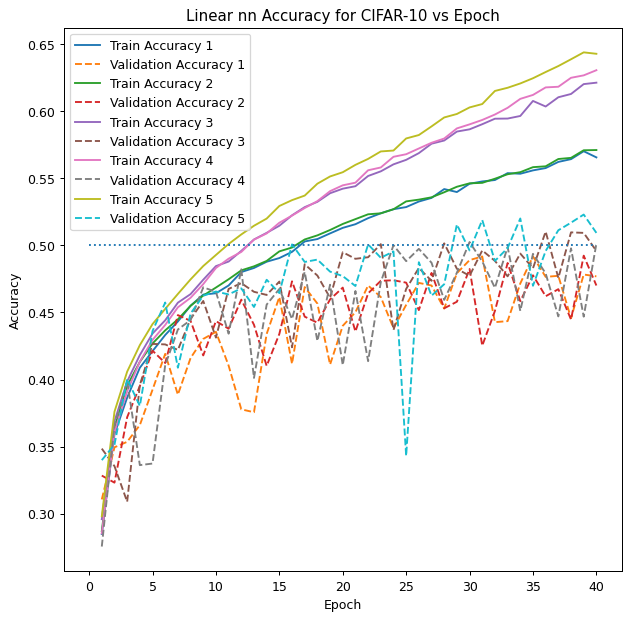

In [7]:
epochs = range(1, 41)
plt.figure(figsize=(8, 8), dpi=90)
plt.plot(epochs, a5a_train_accuracies[0], label="Train Accuracy 1")
plt.plot(epochs, a5a_val_accuracies[0], label="Validation Accuracy 1", linestyle = "dashed")

plt.plot(epochs, a5a_train_accuracies[1], label="Train Accuracy 2",)
plt.plot(epochs, a5a_val_accuracies[1], label="Validation Accuracy 2", linestyle = "dashed")

plt.plot(epochs, a5a_train_accuracies[2], label="Train Accuracy 3")
plt.plot(epochs, a5a_val_accuracies[2], label="Validation Accuracy 3", linestyle = "dashed")

plt.plot(epochs, a5a_train_accuracies[3], label="Train Accuracy 4")
plt.plot(epochs, a5a_val_accuracies[3], label="Validation Accuracy 4", linestyle = "dashed")

plt.plot(epochs, a5a_train_accuracies[4], label="Train Accuracy 5")
plt.plot(epochs, a5a_val_accuracies[4], label="Validation Accuracy 5", linestyle = "dashed")

plt.plot([0, 40], [0.5, 0.5], linestyle = "dotted")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc = "upper left")
plt.title("Linear nn Accuracy for CIFAR-10 vs Epoch")
plt.show()

In [ ]:
_, test_acc_1 = evaluate(model1, test_loader)
_, test_acc_2 = evaluate(model2, test_loader)
_, test_acc_3 = evaluate(model3, test_loader)
_, test_acc_4 = evaluate(model4, test_loader)
_, test_acc_5 = evaluate(model5, test_loader)
print(f"Test Accuracy: {test_acc_1}")
print(f"Test Accuracy: {test_acc_2}")
print(f"Test Accuracy: {test_acc_3}")
print(f"Test Accuracy: {test_acc_4}")
print(f"Test Accuracy: {test_acc_5}")

Test Accuracy: 0.482001582278481
Test Accuracy: 0.463310917721519
Test Accuracy: 0.5046479430379747
Test Accuracy: 0.5000988924050633
Test Accuracy: 0.5026700949367089


Test accuracies for the convolutional model

Test Accuracy: 0.482001582278481 \\
Test Accuracy: 0.463310917721519 \\
Test Accuracy: 0.5046479430379747 \\
Test Accuracy: 0.5000988924050633 \\
Test Accuracy: 0.5026700949367089 \\

convolutional neural network

In [ ]:
def convolutional(M: int, k: int, N: int) -> nn.Module:
  model = nn.Sequential(
      nn.Conv2d(in_channels = 3, out_channels = M, kernel_size = k),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size = N),
      nn.Flatten(),
      nn.Linear(in_features = M * (((33 - k) // 14) ** 2), out_features = 10)
  )

  return model.to(DEVICE)

i changed some of the hyperparameter ranges which hopefully work? print out test accuracies, this is the one i submit

In [ ]:
def a5b_conv_param_search(train_loader: DataLoader,
                      val_loader: DataLoader,
                      model_fn:Callable[[], nn.Module]):
  num_iter = 6
  epochs = 35

  Ms = torch.pow(2, torch.arange(5, 11))
  lr = torch.linspace(10 ** (-5), 10 ** (-1), 6)
  momentums = torch.linspace(0.3, 0.9, num_iter)
  k = 5
  N = 14

  stored_Ms = []
  stored_lrs = []
  stored_momentums = []
  stored_ks = []
  stored_Ns = []

  stored_val_losses = []

  i = 1
  for M in Ms:
    for momentum in momentums:
      print(f"({i}): trying M: {M}, lr: {lr}, momentum: {momentum}, k: {k}, N: {N}")
      i += 1

      model = model_fn(M.item(), k, N)
      optim = SGD(model.parameters(), lr, momentum=momentum)

      train_loss, train_acc, val_loss, val_acc = train(
        model,
        optim,
        train_loader,
        val_loader,
        epochs=35
        )
      
      stored_Ms.append(M)
      stored_lrs.append(lr)
      stored_momentums.append(momentum)
      stored_ks.append(k)
      stored_Ns.append(N)
      
      stored_val_losses.append(min(val_loss))

  indices = torch.argsort(torch.tensor(stored_val_losses))[:5]

  return torch.tensor(stored_Ms)[indices], torch.tensor(stored_lrs)[indices], torch.tensor(stored_momentums)[indices], torch.tensor(stored_ks)[indices], torch.tensor(stored_Ns)[indices]

In [8]:
a5b_stored_best_Ms = torch.tensor([1024, 1024, 1024, 1024, 1024])
a5b_stored_best_lrs = torch.tensor([0.0800, 0.0200, 0.0600, 0.0400, 0.0600])
a5b_stored_best_momentums = torch.tensor([0.6600, 0.9000, 0.6600, 0.7800, 0.7800])
a5b_stored_best_ks = torch.tensor([5, 5, 5, 5, 5])
a5b_stored_best_Ns = torch.tensor([14, 14, 14, 14, 14])

In [ ]:
model_1 = convolutional(a5b_stored_best_Ms[0], 5, 14)
model_2 = convolutional(a5b_stored_best_Ms[1], 5, 14)
model_3 = convolutional(a5b_stored_best_Ms[2], 5, 14)
model_4 = convolutional(a5b_stored_best_Ms[3], 5, 14)
model_5 = convolutional(a5b_stored_best_Ms[4], 5, 14)
optimizer_1 = SGD(model_1.parameters(), a5b_stored_best_lrs[0], momentum = a5b_stored_best_momentums[0])
optimizer_2 = SGD(model_2.parameters(), a5b_stored_best_lrs[1], momentum = a5b_stored_best_momentums[1])
optimizer_3 = SGD(model_3.parameters(), a5b_stored_best_lrs[2], momentum = a5b_stored_best_momentums[2])
optimizer_4 = SGD(model_4.parameters(), a5b_stored_best_lrs[3], momentum = a5b_stored_best_momentums[3])
optimizer_5 = SGD(model_5.parameters(), a5b_stored_best_lrs[4], momentum = a5b_stored_best_momentums[4])

In [ ]:
train_loss, train_accuracy, val_loss, val_accuracy = train(
    model_1, optimizer_1, train_loader, val_loader, 40)
train_loss_2, train_accuracy_2, val_loss_2, val_accuracy_2 = train(
    model_2, optimizer_2, train_loader, val_loader, 40)
train_loss_3, train_accuracy_3, val_loss_3, val_accuracy_3 = train(
    model_3, optimizer_3, train_loader, val_loader, 40)
train_loss_4, train_accuracy_4, val_loss_4, val_accuracy_4 = train(
    model_4, optimizer_4, train_loader, val_loader, 40)
train_loss_5, train_accuracy_5, val_loss_5, val_accuracy_5 = train(
    model_5, optimizer_5, train_loader, val_loader, 40)

In [ ]:
a5b_train_losses = [train_loss, train_loss_2, train_loss_3, train_loss_4, train_loss_5]
a5b_train_accuracies = [train_accuracy, train_accuracy_2, train_accuracy_3, train_accuracy_4, train_accuracy_5]
a5b_val_losses = [val_loss, val_loss_2, val_loss_3, val_loss_4, val_loss_5]
a5b_val_accuracies = [val_accuracy, val_accuracy_2, val_accuracy_3, val_accuracy_4, val_accuracy_5]
print(a5b_train_losses)
print(a5b_train_accuracies)
print(a5b_val_losses)
print(a5b_val_accuracies)

In [9]:
a5b_train_losses = [[1.7784075506708839, 1.4377309486947276, 1.3318312188441104, 1.256117377599532, 1.2131349754265763, 1.165010241791606, 1.1315156819129533, 1.0927815461023287, 1.067361811006611, 1.032843084836548, 1.0164639875292778, 1.0026831239123235, 0.9725683295929973, 0.9623517433012073, 0.9416735792024569, 0.929081183265556, 0.9112594906579364, 0.8971708113835617, 0.8868081810122187, 0.8760893813927065, 0.8583813939582218, 0.8465221698649905, 0.8371764629740607, 0.8270039958032694, 0.8068326415324752, 0.8058258941905065, 0.7924882585013454, 0.7809077186340635, 0.7764605971222575, 0.7632395376197316, 0.7551901332018051, 0.7397001309489663, 0.7324953003024514, 0.7249096497385339, 0.7214435895227573, 0.7128545575859871, 0.7084208750589327, 0.6912736768241633, 0.6846137275411324, 0.6765748827125538], [1.7129530452869155, 1.4160366505384445, 1.3081939521838317, 1.2264667002653533, 1.1849401945417577, 1.1345273632217536, 1.100427525456656, 1.0695301641456105, 1.044029350815849, 1.0068540894849733, 1.0018949700011448, 0.9726522146639499, 0.9483239469541744, 0.9359955574301156, 0.9096493250267073, 0.8947688027877699, 0.8792217228222977, 0.8682330728254535, 0.8597941588271748, 0.8364319152791392, 0.8369351261380044, 0.8131101586940613, 0.7951103138991378, 0.7858532552014698, 0.77134573798288, 0.7632630074566061, 0.7609321969476613, 0.7479772021655332, 0.7304134815084663, 0.7262372079898011, 0.7004650619558312, 0.6953222519633445, 0.6768327269025824, 0.679365751502866, 0.6630337655713613, 0.6589514759623192, 0.644906466149471, 0.6439351193098859, 0.6489429016682234, 0.6253396835686131], [1.7365920645269481, 1.4410851750184188, 1.3343578776852651, 1.2686960981650786, 1.2178432804278352, 1.1748396720398555, 1.1359420068223367, 1.100056325678121, 1.0745525578544899, 1.0560869743878192, 1.027101598510688, 1.00450223447247, 0.9877210648899729, 0.9693884869868105, 0.9506288920952515, 0.9412067065184767, 0.9163380661471323, 0.9102237063714049, 0.8903572628782555, 0.8747815503315493, 0.8562733581797644, 0.8512817873534831, 0.8363145398484035, 0.827913474291563, 0.8142581102861599, 0.8114488407630812, 0.7870432382280176, 0.7911911948838017, 0.7704978085715662, 0.762684249911796, 0.7545380224897102, 0.7475036723031239, 0.7256888585503806, 0.7208380074324933, 0.7169048419560898, 0.696293955668807, 0.69480115827173, 0.691177300600843, 0.6817119765857403, 0.6688155281272802], [1.72902572425929, 1.428882451558655, 1.326429053802382, 1.2552997202358462, 1.2112315845760433, 1.15574713897976, 1.124009239233353, 1.1021092390133576, 1.06770095737143, 1.0394391590221361, 1.0182694338939406, 0.9927973769266497, 0.9819726778024976, 0.9571896471421827, 0.9387404026294296, 0.9231140271506526, 0.9125886291942813, 0.8921050999990918, 0.8830478755249218, 0.8712756938555024, 0.8479211958633228, 0.8483792079443281, 0.8237633244557814, 0.822246165946126, 0.8025145346129482, 0.7888303659856319, 0.7784123984588818, 0.7620471235026013, 0.764718001539057, 0.7460332487455823, 0.7413964672860774, 0.7241567714478482, 0.7255146497521888, 0.7144467948343266, 0.6986413059586828, 0.6828776281327009, 0.6849310587752949, 0.6762233455242082, 0.6747433360327374, 0.65821249156513], [1.7400621748106047, 1.4071604643355717, 1.3106182430955498, 1.2326636375351385, 1.1788860762661153, 1.13693015683781, 1.0959193598140369, 1.0654538626020604, 1.0473787115717477, 1.012679698453708, 0.9897250497544353, 0.974533359604803, 0.947195578366518, 0.9365686229006811, 0.9196121464060112, 0.8954329368743029, 0.8942885620688851, 0.8722746765071695, 0.8508429219099608, 0.8475484079258009, 0.8320267715237357, 0.8253064319830049, 0.8038257949731566, 0.8071589292111722, 0.7882876060903072, 0.7778635631230745, 0.7654857858168808, 0.756437851454724, 0.7430672557516531, 0.7406930730424144, 0.7290034664117477, 0.718335862440819, 0.7055988238955085, 0.7008295768702572, 0.691987805576487, 0.6930013539438898, 0.678812712684951, 0.6754921392791651, 0.6642417793416164, 0.6571263718334112]]
a5b_train_accuracies = [[0.3799715909090909, 0.4929421164772727, 0.5354447798295454, 0.5599698153409091, 0.5757723721590909, 0.5972123579545454, 0.6101296164772727, 0.6247114701704546, 0.6323908025568182, 0.6470836292613636, 0.6540305397727273, 0.6573819247159091, 0.66796875, 0.6691450639204546, 0.677734375, 0.6809303977272727, 0.6888982599431818, 0.6916281960227273, 0.6978204900568182, 0.69921875, 0.7071422230113636, 0.7091841264204546, 0.7132013494318182, 0.7162420099431818, 0.7246315696022727, 0.724609375, 0.7271173650568182, 0.7320445667613636, 0.7357066761363636, 0.7401899857954546, 0.7420099431818182, 0.7446067116477273, 0.750244140625, 0.7515980113636364, 0.7524192116477273, 0.7565030184659091, 0.7576127485795454, 0.7630060369318182, 0.7660910866477273, 0.766357421875], [0.3916237571022727, 0.5060147372159091, 0.5419921875, 0.5774369673295454, 0.5899325284090909, 0.6071111505681818, 0.621337890625, 0.633544921875, 0.6412020596590909, 0.6545188210227273, 0.6566273082386364, 0.6675470525568182, 0.6758478338068182, 0.6823064630681818, 0.6902965198863636, 0.6956232244318182, 0.7002618963068182, 0.7047230113636364, 0.7078524502840909, 0.7139559659090909, 0.714111328125, 0.7229669744318182, 0.7294034090909091, 0.7327547940340909, 0.7359952059659091, 0.7401677911931818, 0.7412997159090909, 0.7433194247159091, 0.7513316761363636, 0.7529962713068182, 0.7606977982954546, 0.7652476917613636, 0.7703524502840909, 0.7686434659090909, 0.7754572088068182, 0.7729714133522727, 0.7798295454545454, 0.7784090909090909, 0.7783203125, 0.7852672230113636], [0.387451171875, 0.4929865056818182, 0.5359330610795454, 0.5577281605113636, 0.5773703835227273, 0.5941938920454546, 0.6086869673295454, 0.6210049715909091, 0.6332341974431818, 0.6369406960227273, 0.6466841264204546, 0.6575150923295454, 0.6613325639204546, 0.6683460582386364, 0.6767134232954546, 0.6792436079545454, 0.6880104758522727, 0.6888316761363636, 0.6959561434659091, 0.7016379616477273, 0.7094060724431818, 0.7094948508522727, 0.7144664417613636, 0.7195712002840909, 0.7215243252840909, 0.7230335582386364, 0.7341752485795454, 0.728759765625, 0.7379483309659091, 0.7393465909090909, 0.7425204190340909, 0.7445401278409091, 0.7535733309659091, 0.7549050071022727, 0.7549493963068182, 0.7643821022727273, 0.7654252485795454, 0.7632501775568182, 0.7665127840909091, 0.771240234375], [0.38682972301136365, 0.49882368607954547, 0.5385520241477273, 0.5657848011363636, 0.5819424715909091, 0.6000088778409091, 0.6109952059659091, 0.6215154474431818, 0.6325905539772727, 0.6442427201704546, 0.6510342684659091, 0.6607998934659091, 0.6664817116477273, 0.6758034446022727, 0.6788441051136364, 0.6847700639204546, 0.6890092329545454, 0.6945134943181818, 0.6977761008522727, 0.7029030539772727, 0.7115367542613636, 0.7084738991477273, 0.71923828125, 0.7203258167613636, 0.7255637428977273, 0.7325328480113636, 0.7340642755681818, 0.7406560724431818, 0.7377041903409091, 0.7447398792613636, 0.7463822798295454, 0.7526411576704546, 0.7547274502840909, 0.7567693536931818, 0.7629616477272727, 0.7654696377840909, 0.7666237571022727, 0.7685768821022727, 0.7695534446022727, 0.7732377485795454], [0.38880504261363635, 0.5051047585227273, 0.5419034090909091, 0.5708229758522727, 0.5915971235795454, 0.6064453125, 0.6221147017045454, 0.6329678622159091, 0.6393821022727273, 0.6532315340909091, 0.6630637428977273, 0.665283203125, 0.6769575639204546, 0.6787997159090909, 0.6844149502840909, 0.6931374289772727, 0.6945134943181818, 0.7004838423295454, 0.7082075639204546, 0.7100275213068182, 0.716796875, 0.7161976207386364, 0.7224343039772727, 0.7221235795454546, 0.7292924360795454, 0.732666015625, 0.737060546875, 0.7401012073863636, 0.7441850142045454, 0.7455832741477273, 0.7481356534090909, 0.7544167258522727, 0.7564142400568182, 0.7586337002840909, 0.760986328125, 0.7620960582386364, 0.7642045454545454, 0.7661354758522727, 0.7700417258522727, 0.7726162997159091]]
a5b_val_losses = [[1.5655976742506028, 1.3963831067085266, 1.3190482884645462, 1.285090345144272, 1.1842646718025207, 1.1781110033392905, 1.2044517546892166, 1.1658358544111251, 1.1269395604729653, 1.144325076043606, 1.1231994420289992, 1.1455506503582, 1.0182002529501915, 1.1665931209921836, 1.0535438820719718, 1.0705567941069603, 1.0929344102740288, 1.0644094094634056, 1.0451778545975685, 1.1074789851903915, 1.0092910081148148, 1.0704100653529167, 1.0773278638720512, 1.033614307641983, 0.9371625527739524, 1.080445683002472, 1.016153635084629, 1.0667413741350174, 0.9933030039072037, 1.0601032644510269, 1.0384751126170157, 1.0301920726895333, 1.1099111706018447, 0.9841205686330795, 1.0587839752435684, 1.0171958848834037, 1.047957293689251, 1.0233655765652656, 1.0458671301603317, 0.9734011679887772], [1.513268408179283, 1.3747070342302323, 1.3019877135753632, 1.2758715957403184, 1.1759078055620193, 1.1760823398828506, 1.1543381825089454, 1.098723790049553, 1.0578299179673194, 1.1890966176986695, 1.0396249800920487, 1.1020448744297027, 1.0826002940535546, 1.0647443428635597, 0.9958298683166504, 1.0413264989852906, 1.1108571588993073, 1.047364141047001, 0.981288594007492, 1.0091863930225373, 1.0793118178844452, 1.0274139031767846, 0.9688847586512566, 0.9372925609350204, 1.0202151879668235, 0.945965439081192, 1.0281192481517791, 0.9344085216522217, 0.9610651835799218, 0.9212571680545807, 0.9983295381069184, 0.9096237152814866, 0.9598172143101692, 0.9618901014328003, 0.9990213632583618, 1.0358095958828926, 1.0074639916419983, 1.0772795021533965, 0.9557497963309288, 0.9335545226931572], [1.6622334122657776, 1.4224862158298492, 1.3248430237174034, 1.2902903407812119, 1.2557401299476623, 1.216827616095543, 1.2077743530273437, 1.1106926679611206, 1.0985313400626182, 1.1716050073504447, 1.0718852132558823, 1.0947488024830818, 1.0802558809518814, 1.014692023396492, 1.1370791003108025, 1.0089283376932143, 1.0844287991523742, 1.0406236931681634, 1.0600083231925965, 1.0517213016748428, 1.073353184759617, 1.0146382302045822, 1.0162255316972733, 1.1008418381214142, 0.9819896250963212, 1.1750887580215932, 1.0170021563768388, 1.0390363916754723, 1.0438886180520057, 1.050899587571621, 1.084867125749588, 0.9853161200881004, 1.018677568435669, 1.0252774998545646, 1.071724571287632, 0.9546704187989234, 0.9214951977133751, 1.007592961192131, 1.0354547321796417, 0.9933191135525703], [1.5239570379257201, 1.4112355917692185, 1.3159384429454803, 1.330892312526703, 1.344026692211628, 1.1783560037612915, 1.2067612037062645, 1.1922819584608078, 1.137100425362587, 1.125764176249504, 1.100405828654766, 1.104533815383911, 1.0344666063785553, 1.0425182223320006, 1.1271056443452836, 1.0592205673456192, 1.0610340416431427, 1.039922794699669, 1.2394075393676758, 1.024507722258568, 1.0400980889797211, 1.0274406537413596, 1.0287658452987671, 0.9591583371162414, 1.007278423011303, 1.0852831050753593, 0.9477753326296806, 0.9929069608449936, 0.9836767196655274, 0.9914099931716919, 0.9802878394722938, 1.023570293188095, 0.9918204456567764, 0.9710506916046142, 1.0990658700466156, 1.0296039536595345, 1.0434439018368722, 0.9946779191493988, 1.091201214492321, 0.9201464802026749], [1.4758334308862686, 1.361129179596901, 1.3736602395772934, 1.260903960466385, 1.2127457156777381, 1.2144532948732376, 1.1317552149295806, 1.074539139121771, 1.116829513013363, 1.102541583776474, 1.109915891289711, 1.0730265468358993, 1.1215654224157334, 1.0220529541373253, 1.0369486927986145, 1.0095443233847619, 1.0461475357413292, 1.0613267585635184, 0.9772904083132744, 1.0557504922151566, 0.987216591835022, 0.9966970667243004, 1.0623862624168396, 1.0491142451763154, 1.0093629121780396, 0.9922069326043129, 1.006938973069191, 1.0338152304291726, 1.0646129205822945, 1.0245466127991676, 0.9836091205477715, 0.9743992373347282, 1.0268337294459342, 0.9847849652171135, 1.0031307145953179, 1.0003448009490967, 1.0646070331335067, 1.0724892698228359, 1.0539924174547195, 1.1366707503795623]]
a5b_val_accuracies = [[0.42265625, 0.487109375, 0.5255859375, 0.5509765625, 0.57109375, 0.5796875, 0.5466796875, 0.58359375, 0.612109375, 0.597265625, 0.598046875, 0.590625, 0.6349609375, 0.5982421875, 0.634375, 0.619921875, 0.6158203125, 0.631640625, 0.633984375, 0.616796875, 0.641796875, 0.6357421875, 0.629296875, 0.64296875, 0.6673828125, 0.627734375, 0.651171875, 0.63359375, 0.6494140625, 0.62265625, 0.6466796875, 0.637890625, 0.6330078125, 0.6611328125, 0.6353515625, 0.6609375, 0.6478515625, 0.6578125, 0.6439453125, 0.6720703125], [0.4427734375, 0.5025390625, 0.5419921875, 0.540234375, 0.591015625, 0.5763671875, 0.584765625, 0.6095703125, 0.6255859375, 0.5662109375, 0.630859375, 0.60859375, 0.614453125, 0.613671875, 0.6529296875, 0.634765625, 0.6248046875, 0.63359375, 0.6462890625, 0.6423828125, 0.6216796875, 0.6423828125, 0.6587890625, 0.6740234375, 0.6490234375, 0.6740234375, 0.64609375, 0.6689453125, 0.66328125, 0.6796875, 0.6560546875, 0.67734375, 0.66484375, 0.665234375, 0.65859375, 0.6466796875, 0.6521484375, 0.64609375, 0.6775390625, 0.6791015625], [0.386328125, 0.4859375, 0.5177734375, 0.5322265625, 0.5455078125, 0.5705078125, 0.5654296875, 0.6076171875, 0.6115234375, 0.5767578125, 0.623828125, 0.6197265625, 0.612890625, 0.6431640625, 0.590234375, 0.6443359375, 0.6134765625, 0.635546875, 0.6271484375, 0.6328125, 0.623828125, 0.637890625, 0.63515625, 0.61953125, 0.6482421875, 0.60390625, 0.6509765625, 0.6380859375, 0.637890625, 0.6416015625, 0.63203125, 0.65859375, 0.6583984375, 0.6423828125, 0.6306640625, 0.6666015625, 0.6796875, 0.6560546875, 0.6513671875, 0.646484375], [0.4494140625, 0.48984375, 0.521484375, 0.5119140625, 0.51875, 0.5791015625, 0.571875, 0.5775390625, 0.591015625, 0.6185546875, 0.6275390625, 0.6146484375, 0.6373046875, 0.6318359375, 0.5962890625, 0.62734375, 0.6265625, 0.6330078125, 0.573828125, 0.6451171875, 0.6271484375, 0.6365234375, 0.6373046875, 0.664453125, 0.6416015625, 0.6287109375, 0.6615234375, 0.6568359375, 0.659765625, 0.6576171875, 0.657421875, 0.6517578125, 0.651171875, 0.67578125, 0.6337890625, 0.6458984375, 0.651953125, 0.6654296875, 0.6212890625, 0.684765625], [0.4728515625, 0.5126953125, 0.5005859375, 0.5474609375, 0.579296875, 0.5685546875, 0.6068359375, 0.612109375, 0.6017578125, 0.61015625, 0.6166015625, 0.6294921875, 0.6103515625, 0.6416015625, 0.6423828125, 0.648046875, 0.632421875, 0.634375, 0.6599609375, 0.6232421875, 0.64765625, 0.6578125, 0.620703125, 0.635546875, 0.6513671875, 0.6595703125, 0.6525390625, 0.64921875, 0.631640625, 0.6568359375, 0.66484375, 0.6640625, 0.6595703125, 0.666015625, 0.6607421875, 0.6580078125, 0.6408203125, 0.636328125, 0.655078125, 0.62578125]]

In [ ]:
print(max(val_accuracy))
print(max(val_accuracy_2))
print(max(val_accuracy_3))
print(max(val_accuracy_4))
print(max(val_accuracy_5))

In [ ]:
_, test_acc_1 = evaluate(model_1, test_loader)
_, test_acc_2 = evaluate(model_2, test_loader)
_, test_acc_3 = evaluate(model_3, test_loader)
_, test_acc_4 = evaluate(model_4, test_loader)
_, test_acc_5 = evaluate(model_5, test_loader)
print(f"Test Accuracy: {test_acc_1}")
print(f"Test Accuracy: {test_acc_2}")
print(f"Test Accuracy: {test_acc_3}")
print(f"Test Accuracy: {test_acc_4}")
print(f"Test Accuracy: {test_acc_5}")

Test Accuracy: 0.6798852848101266
Test Accuracy: 0.6870055379746836
Test Accuracy: 0.6590189873417721
Test Accuracy: 0.6926424050632911
Test Accuracy: 0.646064082278481


Test accuracies for the convolutional model

Test Accuracy: 0.6798852848101266 \\
Test Accuracy: 0.6870055379746836 \\
Test Accuracy: 0.6590189873417721 \\
Test Accuracy: 0.6926424050632911 \\
Test Accuracy: 0.646064082278481 \\

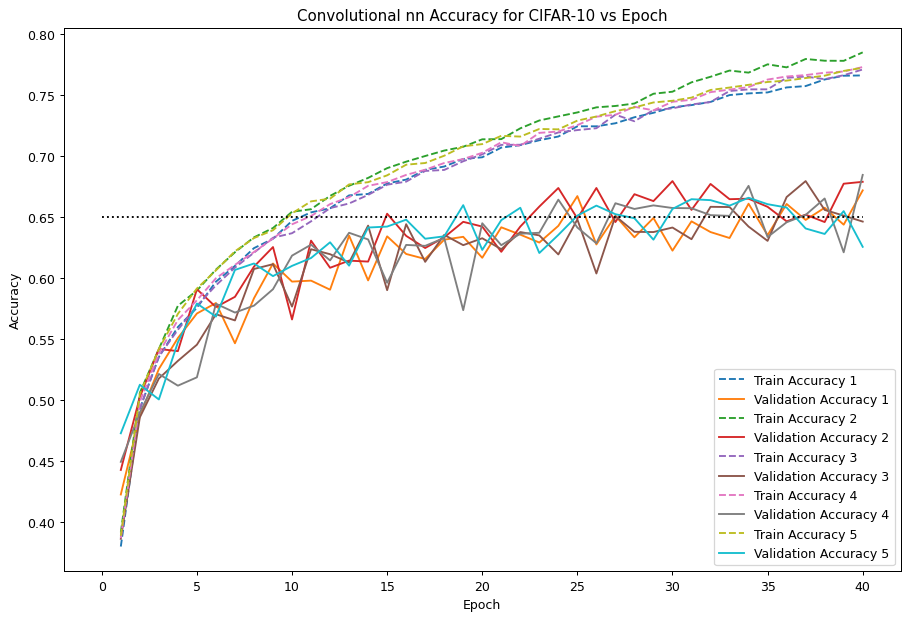

In [11]:
epochs = range(1, 41)
plt.figure(figsize=(12, 8), dpi=90)
plt.plot(epochs, a5b_train_accuracies[0], label="Train Accuracy 1", linestyle = "dashed")
plt.plot(epochs, a5b_val_accuracies[0], label="Validation Accuracy 1")

plt.plot(epochs, a5b_train_accuracies[1], label="Train Accuracy 2",linestyle = "dashed")
plt.plot(epochs, a5b_val_accuracies[1], label="Validation Accuracy 2")

plt.plot(epochs, a5b_train_accuracies[2], label="Train Accuracy 3", linestyle = "dashed")
plt.plot(epochs, a5b_val_accuracies[2], label="Validation Accuracy 3")

plt.plot(epochs, a5b_train_accuracies[3], label="Train Accuracy 4", linestyle = "dashed")
plt.plot(epochs, a5b_val_accuracies[3], label="Validation Accuracy 4")

plt.plot(epochs, a5b_train_accuracies[4], label="Train Accuracy 5", linestyle = "dashed")
plt.plot(epochs, a5b_val_accuracies[4], label="Validation Accuracy 5")

plt.plot([0, 40], [0.65, 0.65], linestyle = "dotted", color = "black")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc = "lower right")
plt.title("Convolutional nn Accuracy for CIFAR-10 vs Epoch")
plt.show()